In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
from classical_optimization.qaoa_circuits import produce_gammas_betas, maxcut_qaoa_circuit, estimate_cost
from qiskit import Aer, execute
from qiskit.providers.aer.extensions import snapshot_density_matrix
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import numpy as np

discretization = 50
max_gamma = 2*np.pi
max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

In [3]:
def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

# def Z(i, j, num_qubits):
#     rtn = np.eye(1)
#     z = np.array([[1, 0], [0, -1]])
#     for k in range(num_qubits):
#         if k == i or k == j:
#             rtn = np.kron(rtn, z)
#         else:
#             rtn = np.kron(rtn, np.eye(2))
#     return rtn

# def cost(density_matrix, num_qubits, weights):
#     rtn = 0
#     for edge, weight in weights.items():
#         rtn += .5 * weight * (1 - np.trace(Z(*edge, num_qubits).dot(density_matrix)))
#     return rtn

In [4]:
# def execute_qaoa_circuit_and_estimate_cost(gamma, beta, num_shots, simulator, coupling_map, weights, rows, cols,
#                                            *, noise_model=None, seed=None):
#     """Build and run the a qaoa circuit with the given parameters on the given simulator."""
#     circuit = maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights)
#     job = execute(experiments, backend=simulator,  noise_model=noise_model, backend_options=backend_options)    
#     outputs = [result.data.snapshots.density_matrix['output'][0]['value'] for result in job.result().results]
#     # The diagonal is real, so we take the first element.
#     expectations = [cost(np.array(output)[:, :, 0], num_qubits=num_qubits, weights=weights(graph)) for output in outputs]
#     return expectations

In [5]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost

np.random.seed(666)
shots_per_point = 100

history = []
def store_log(func):
    def logged_func(x):
        history.append(x)
        return func(x)
    return logged_func

@store_log
def gamma_beta_objective(gamma_beta):
    # The cut value is the expectation value, minima of the negation correspond to maxima.
    return execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[1] * np.pi, beta=gamma_beta[0] * np.pi,
                                                   num_shots=shots_per_point,
                                                   simulator=simulator,
                                                   coupling_map=coupling_map,
                                                   weights=weights(graph),
                                                   rows=num_rows,
                                                   cols=num_cols,
                                                   noise_model=noise_model,
                                                   seed=np.random.randint(0,1000000))

# @store_log
# def gamma_beta_objective(gamma_beta):
#     from classical_optimization.terra.utils import cost
#     rows = 2
#     cols = 2
#     num_qubits = rows * cols
#     simulator = Aer.get_backend('statevector_simulator')
#     gamma = gamma_beta[1]/np.pi
#     beta = gamma_beta[0]/np.pi
#     experiments = []
#     circuit = maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, num_qubits=num_qubits, weights=weights(graph), measure=False)
#     experiments.append(circuit)
#     job = execute(experiments, backend=simulator)
#     expectations = [np.real(cost(job.result().get_statevector(experiment), num_qubits=num_qubits, weights=weights(graph))) for experiment in experiments]
#     expectation = expectations[0]
#     return expectation

In [6]:
import networkx as nx
import numpy as np
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend


seed = 666
num_rows = 2
num_cols = 2
neutral_atom = ColdQuantaSimBackend(rows=num_rows, cols=num_cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

np.random.seed(seed)
g = nx.Graph(coupling_map)

num_graphs = 10
graphs = []
for _ in range(num_graphs):
    graph = nx.generators.random_graphs.random_regular_graph(3, num_cols*num_rows)
    for edge in graph.edges:
        graph.add_weighted_edges_from([(edge[0], edge[1], 1.0)])
    graphs.append(graph)

In [7]:
# # We can control the maximum number of iterations, and we should fix the total number of function evaluations
# # at the time we are considering. Additionally, we need to consider the number of shots to perform per evaluation.

# # Then we need to sweep initial_temp, visit, and accept.
# initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
# result = dual_annealing(
#     gamma_beta_objective,
#     bounds=[(0, np.pi),
#             (0, 2*np.pi)],
#     x0=np.array(initial_gamma_beta),
#     # One annealing attempt.
#     maxiter=10,
#     initial_temp=10,
#     maxfun=one_hour*reprate,
#     # It looks like the algorithm will randomly reinitialize if the temperature drops below a certain point. This seems
#     # like it would only be useful if the scipy function reports the best found solution.
#     restart_temp_ratio=1E-10,
#     # Don't use local search around reported minima, for now.
#     no_local_search=True)
# result.fun = -result.fun

In [8]:
# noise_model = create_noise_model(cz_fidelity=1)
# num_qubits = num_rows*num_cols


# simulator = Aer.get_backend('qasm_simulator')
# backend_options = {}

# experiments = []
# for gamma in gammas:
#     for beta in betas:
#         circuit = maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=num_rows, cols=num_cols, weights=weights(graph), measure=False, density_matrix=True)
#         experiments.append(circuit)

# job = execute(experiments, backend=simulator,  noise_model=noise_model, backend_options=backend_options)    
# outputs = [result.data.snapshots.density_matrix['output'][0]['value'] for result in job.result().results]
# # The diagonal is real, so we take the first element.
# expectations = [cost(np.array(output)[:, :, 0], num_qubits=num_qubits, weights=weights(graph)) for output in outputs]
# landscape = np.zeros((discretization, discretization))
# for i, gamma in enumerate(gammas):
#     for j, beta in enumerate(betas):
#         landscape[i][j] = expectations[i*len(betas) + j]
# plot_landscape(landscape, max_gamma, max_beta)  
# plt.show()

In [9]:
MAX_ITERATION = 100
fit_func = gamma_beta_objective
simulator = Aer.get_backend('qasm_simulator')
graph = graphs[0]
noise_model = create_noise_model(cz_fidelity=1)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    fit_hist = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append(result[0])
        fit_hist.append(result[1])
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, fit_hist, result

In [146]:
from es import SimpleGA, CMAES, PEPG, OpenES
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
NPARAMS = 2
NPOPULATION = 100
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.999, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)
oes.mu = np.array([1.18, 1.78]) / np.pi
oes_history, fit_hist, oes_result = test_solver(oes)

fitness at iteration 100 3.808317931592483
local optimum discovered by solver:
 [0.41143372 0.40882267]
fitness score at this local optimum: 3.808317931592483


# 100 shots per point, forget best True, NPOPULATION 100, but with the argument being multiplied by pi, so effectively the spread is greater. Much better, it seems.

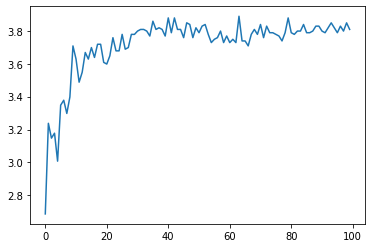

In [147]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

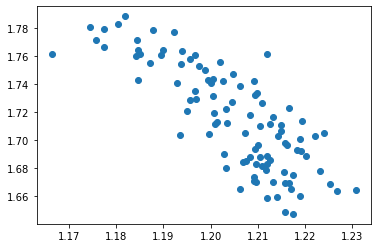

In [138]:
oes_hist = np.array(oes_history)/np.pi
plt.scatter(oes_hist[:, 0], oes_hist[:, 1])

# Everything below was done with the argument being divided by pi. So it samples by X, then divides. I think we want the opposite, so that a smaller sigma results in a bigger spread. so multiple in the argument by pi.

# 10 shots per point, forget best True,
notice it's only improving now because it's sampling more - we at least need more population (we have 100 here)

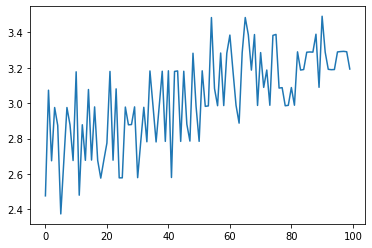

In [133]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

# 10 shots per point, forget best True,
notice it's only improving now because it's sampling more - we at least need more population (we have 10 here)

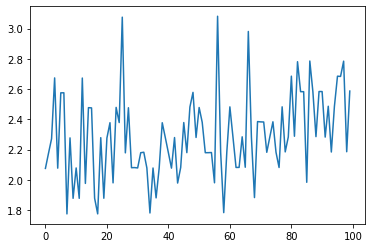

In [131]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

# 10 shots per point, forget best false

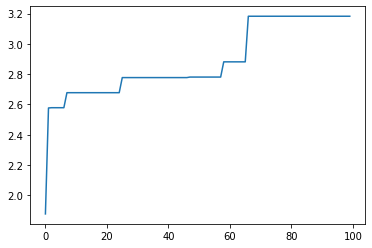

In [129]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

# 100 shots per point, forget best false

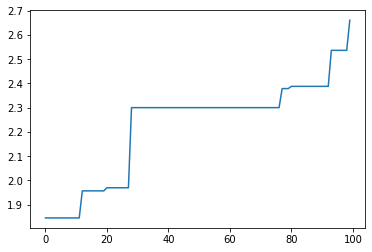

In [122]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

# 100 shots per point, forget best True, NPOPULATION 100

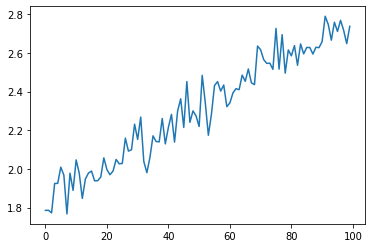

In [118]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

# 100 shots per point, forget best True, NPOPULATION 10

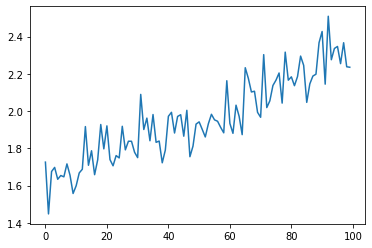

In [116]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

In [90]:
from es import SimpleGA, CMAES, PEPG, OpenES
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.999, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=False)
oes.mu = np.array([1.18, 1.78]) * np.pi
oes_history, fit_hist, oes_result = test_solver(oes)

fitness at iteration 100 2.47549250517317
fitness at iteration 200 3.214629182433362
fitness at iteration 300 3.5138169621006967
fitness at iteration 400 3.529418161725391
fitness at iteration 500 3.5295736858293356
local optimum discovered by solver:
 [4.03178289 4.15040746]
fitness score at this local optimum: 3.5295736858293356


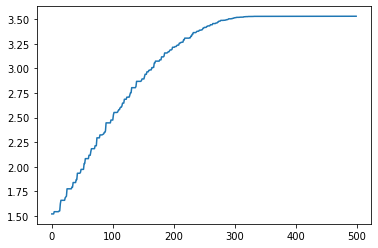

In [91]:
import matplotlib.pyplot as plt
plt.plot(fit_hist)

In [45]:
gamma_beta_objective(oes)

3.127951719608621

In [42]:
oes_history

[array([-0.06164162,  0.04332392]),
 array([-0.06164162,  0.04332392]),
 array([-0.06164162,  0.04332392]),
 array([-0.06164162,  0.04332392]),
 array([-0.06164162,  0.04332392]),
 array([ 0.04106873, -0.07551372]),
 array([ 0.04106873, -0.07551372]),
 array([ 0.04106873, -0.07551372]),
 array([ 0.04106873, -0.07551372]),
 array([ 0.06926852, -0.07086254]),
 array([ 0.06926852, -0.07086254]),
 array([ 0.06926852, -0.07086254]),
 array([ 0.06926852, -0.07086254]),
 array([ 0.05609611, -0.12197114]),
 array([ 0.05609611, -0.12197114]),
 array([ 0.06215173, -0.145464  ]),
 array([ 0.0917201 , -0.10329128]),
 array([ 0.0917201 , -0.10329128]),
 array([ 0.0917201 , -0.10329128]),
 array([ 0.09512311, -0.10752478]),
 array([ 0.11884349, -0.08704215]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.14617103]),
 array([ 0.11799142, -0.1461

In [7]:
def the_whole_schebang(rows, cols, noise_model=None):
    neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
    neutral_atom_config = neutral_atom.configuration()
    coupling_map = neutral_atom_config.coupling_map
    g = graphs[0]
    #draw_planar(g)
    #np.random.seed(137)
    weights = set()
    for k in coupling_map:
        weights.add((min(k), max(k)))
    # Fix the weights to 1, for now.
    weights = {k: 1  for k in weights}

    def produce_gammas_betas(discretization, max_gamma, max_beta):
        return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

    discretization = 20
    max_gamma = max_beta = np.pi
    gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

    simulator = Aer.get_backend('qasm_simulator')
    num_shots = 1024
    experiments = []
    for gamma in gammas:
        for beta in betas:
            experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
    job = execute(experiments, backend=simulator, shots=num_shots, noise_model=noise_model)    
    all_counts = job.result().get_counts()    
    landscape = np.zeros((discretization, discretization))
    for i, gamma in enumerate(gammas):
        for j, beta in enumerate(betas):
            landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)
    return landscape, max_gamma, max_beta, betas, gammas, all_counts

In [13]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
from classical_optimization.qaoa_circuits import plot_landscape
landscape, max_gamma, max_beta, betas, gammas, all_counts = the_whole_schebang(rows, cols)


TypeError: plot_landscape() missing 2 required positional arguments: 'max_gamma' and 'max_beta'

> <ipython-input-13-c85e9d431893>(4)<module>()
      1 from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
      2 from classical_optimization.qaoa_circuits import plot_landscape
      3 landscape, max_gamma, max_beta, betas, gammas, all_counts = the_whole_schebang(2, 2)
----> 4 plot_landscape(landscape)

ipdb> c


/home/ampolloreno/repos/qaoa/classical_optimization/classical_optimization/qaoa_circuits.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(ticks)
/home/ampolloreno/repos/qaoa/classical_optimization/classical_optimization/qaoa_circuits.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels(ticks)


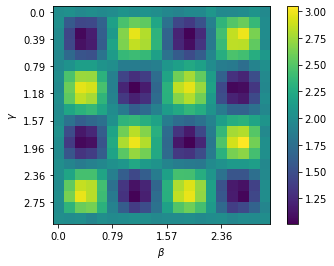

In [14]:
plot_landscape(landscape, max_gamma, max_beta)

In [70]:
(1.96-1.57)/2 + 1.57

1.7650000000000001

In [71]:
.79/2 + .79

1.185

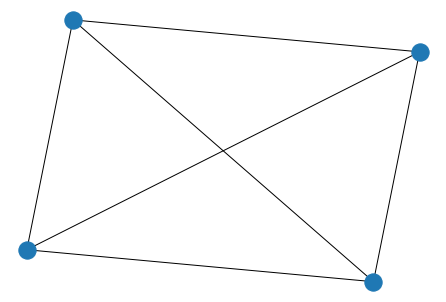

In [43]:
import networkx as nx
nx.draw(graphs[0])